# Classification Metrics

In the last notebook we fit binary classifier to predict whether patients were diabetic or not. We used accuracy as a measure of how well the model performed, but accuracy isn't everything. In this notebook, we will look at alternatives to accuracy that can be much more useful in machine learning.

## Alternative metrics for binary classifiers

Accuracy seems like a sensible metric to evaluate (and to a certain extent it is), but you need to be careful about drawing too many conclusions from the accuracy of a classifier. Remember that it's simply a measure of how many cases were predicted correctly. Suppose only 3% of the population is diabetic. You could create a classifier that always just predicts 0, and it would be 97% accurate - but not terribly helpful in identifying patients with diabetes!

Fortunately, there are some other metrics that reveal a little more about how our model is performing. Scikit-Learn includes the ability to create a *classification report* that provides more insight than raw accuracy alone.

To get started, run the next cell to load our data and train our model like last time.

In [6]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Memuat data set
url = 'https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/diabetes.csv'
diabetes = pd.read_csv(url)
diabetes.head()

# Memisahkan Fitur dan Label
features = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']
label = 'Diabetic'
X, y = diabetes[features].values, diabetes[label].values

# Memisahkan data 70%-30% ke dalam set pelatihan dan uji test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

# Melatih model
from sklearn.linear_model import LogisticRegression

# Menetapkan nilai regularisasi
reg = 0.01

# Melatih model regresi logistic pada training set
model = LogisticRegression(C=1/reg, solver='liblinear').fit(X_train, y_train)

predictions = model.predict(X_test)
print('Prediction Labels: ' , predictions)
print('Actual Labels: ', y_test)

print('Accuracy: ', accuracy_score(y_test, predictions))

Training cases: 10500
Test cases: 4500
Prediction Labels:  [0 0 0 ... 0 1 0]
Actual Labels:  [0 0 1 ... 1 1 1]
Accuracy:  0.7893333333333333


In [8]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      2986
           1       0.72      0.60      0.66      1514

    accuracy                           0.79      4500
   macro avg       0.77      0.74      0.75      4500
weighted avg       0.78      0.79      0.78      4500



In [10]:
from sklearn.metrics import precision_score, recall_score

print('Overall Precision:', precision_score(y_test, predictions))
print('Overall Recall:', recall_score(y_test, predictions))

Overall Precision: 0.7242472266244057
Overall Recall: 0.6036988110964333


In [12]:
from sklearn.metrics import confusion_matrix

# print model
cm = confusion_matrix(y_test, predictions)
print(cm)

[[2638  348]
 [ 600  914]]


In [14]:
y_scores = model.predict_proba(X_test)
print(y_scores)

[[0.81657116 0.18342884]
 [0.9630332  0.0369668 ]
 [0.80872619 0.19127381]
 ...
 [0.60692458 0.39307542]
 [0.10656641 0.89343359]
 [0.63859127 0.36140873]]


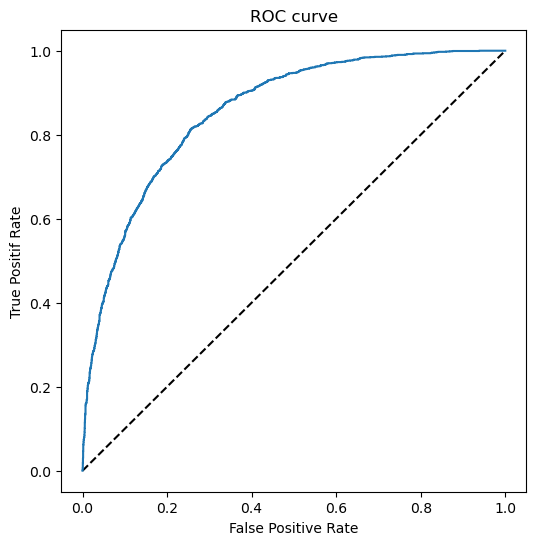

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Menkalkulasi Kurva ROC
fpr, tpr, thtrholds = roc_curve(y_test, y_scores[:,1])

# Membuat Plot Kurva ROC
fig = plt.figure(figsize=(6,6))

# Membuat plot nilai diagonal 50% satu baris
plt.plot([0, 1], [0,1], 'k--')

# Membuat plot the FPR dan TP simpanan model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positif Rate')
plt.title('ROC curve')
plt.show()

In [21]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.8568444904932839


### Perform Preprocessing in a pipeline

In this case, the ROC curve and its AUC indicate that the model performs better than a random guess which is not bad considering we performed very little preprocessing of the data.

In [27]:
# Melatih Model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np

# Menentukan preprocessing untuk kolom numerik
numeric_features = [0, 1, 2, 3, 4, 5, 6]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Menentukan preprocessing untuk fitur kategorid
categorical_features = [7]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Menggabungkan langkah-langkah preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Membuat pipeline pemrosesan 
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('logregressor', LogisticRegression(C=1/reg, solver="liblinear"))])

# menyesuaikan pipa untuk dilatih secara regresi logistic regression
model = pipeline.fit(X_train, (y_train))
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('logregressor',
                 LogisticRegression(C=100.0, solver='liblinear'))])


Confusion Matrix:
 [[2638  348]
 [ 600  914]] 

Accuracy:  0.7893333333333333
Overall Precision:  0.7242472266244057
Overall Recall:  0.6036988110964333
AUC: 0.9202440539337694


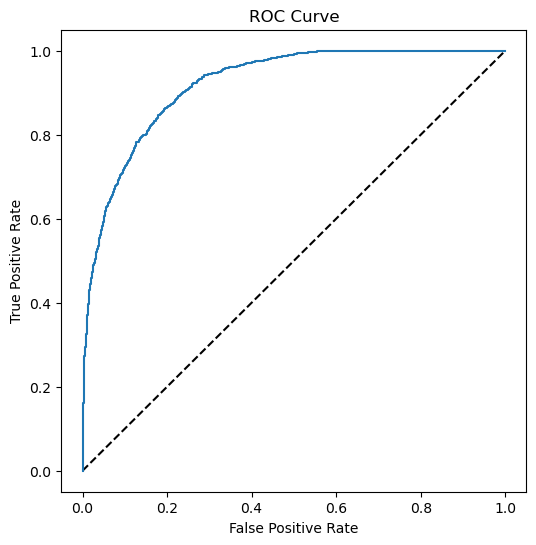

In [32]:
# Mendapatkan prediksi dari data uji
preidctions = model.predict(X_test)
y_scores = model.predict_proba(X_test)

# Mendapatkan metrik evaluasi
cm = confusion_matrix(y_test, predictions)
print('Confusion Matrix:\n', cm, '\n')
print('Accuracy: ', accuracy_score(y_test, predictions))
print('Overall Precision: ', precision_score(y_test, predictions))
print('Overall Recall: ', recall_score(y_test, predictions))
auc = roc_auc_score(y_test, y_scores[:,1])
print('AUC: ' + str(auc))

# Menghitung kurva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# Membuat Plot Kurva ROC
fig = plt.figure(figsize=(6,6))

# Membuat Plot diagonal 50%
plt.plot([0, 1], [0, 1], 'k--')

# Membuat Plot FPR dan TPR yang dicapai 
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Try a Different Algorithm

There are many kinds of classification algorithm we could try, including:

- **Support Vector Machine algorithms**: Algorithms that define a *hyperplane* that separates classes.
- **Tree-based algorithms**: Algorithms that build a decision tree to reach a prediction
- **Ensemble algorithms**: Algorithms that combine the outputs of multiple base algorithms to improve generalizability.

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Membuat pipeline prapemrosessan dan pelatihan
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('logregressor', RandomForestClassifier(n_estimators=100))])

# Menyesuaikan alur untuk melatih model acak pada set pelatihan
model = pipeline.fit(X_train, (y_train))
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('logregressor', RandomForestClassifier())])


Confusion Metrix: 
 [[2858  128]
 [ 179 1335]] 

Accuracy:  0.9317777777777778
Overall Precision:  0.9125085440874915
Overall Recall:  0.881770145310436

AUC: 0.9821574879158663


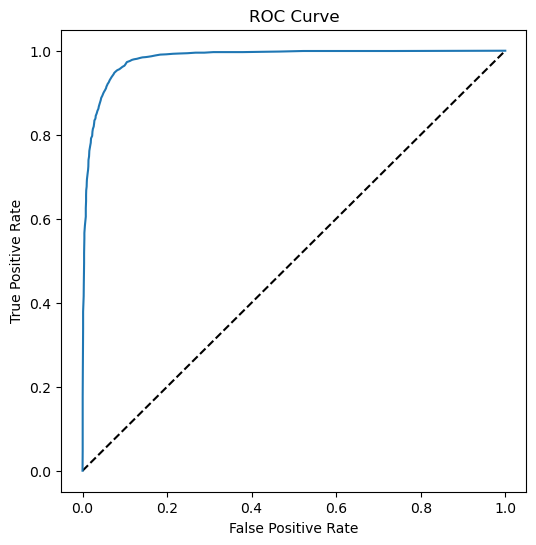

In [37]:
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)
cm = confusion_matrix(y_test, predictions)
print('Confusion Metrix: \n', cm, '\n')
print('Accuracy: ', accuracy_score(y_test, predictions))
print('Overall Precision: ', precision_score(y_test, predictions))
print('Overall Recall: ', recall_score(y_test, predictions))
auc = roc_auc_score(y_test, y_scores[:,1])
print('\nAUC: ' + str(auc))

# Menghitung kurva ROC 
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# Membuat Kurva ROC
fig = plt.figure(figsize=(6,6))

# Membuat Plot garis diagonal 50%
plt.plot([0,1], [0,1], 'k--')

# Membuat FPR da TPR yang di capai model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Use the Model for Inferencing

In [38]:
import joblib

# Menyimpan model sebagai file acak
filename='./diabetes_model.pkl'
joblib.dump(model, filename)

['./diabetes_model.pkl']

In [41]:
# Memuat model dari file
model = joblib.load(filename)


# Memprediksi sample baru
X_new = np.array([[2,180,74,24,21,23.9091702,1.488172308,22]])
print('New Sample: {}'.format(list(X_new[0])))

# Mendapatkan hasil Prediksi
pred = model.predict(X_new)

# Mengambalikan array prediksi
print('Predicted class is {}'.format((pred[0])))

New Sample: [2.0, 180.0, 74.0, 24.0, 21.0, 23.9091702, 1.488172308, 22.0]
Predicted class is 1


## Summary

Dalam perancangan algoritma yang telah kita pelajari terhadapt metrix untuk klasifikasi biner, algoritma random forest, dan algoritma logistik.